In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib notebook
import load_raw as Raw
import seaborn as sns
from scipy.special import expit as logit
from scipy.special import expit as logit
from sklearn.model_selection import train_test_split
from scipy.special import expit as sigmoid # is more stable in case of overflows
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import random
import math

df_cleaned = pd.read_csv('/data/ortho/AllPatients.csv',  sep= ';')

# x is naar rechts
# y is omhoog
# z is rotatie????

print(df_cleaned.columns.values)
#print(df_cleaned['Oorsprong'])

['Unnamed: 0' 'thorax_r_x' 'thorax_r_y' 'thorax_r_z' 'clavicula_r_x'
 'clavicula_r_y' 'clavicula_r_z' 'scapula_r_x' 'scapula_r_y' 'scapula_r_z'
 'humerus_r_x' 'humerus_r_y' 'humerus_r_z' 'ellebooghoek_r' '13' '14'
 'thorax_l_x' 'thorax_l_y' 'thorax_l_z' 'clavicula_l_x' 'clavicula_l_y'
 'clavicula_l_z' 'scapula_l_x' 'scapula_l_y' 'scapula_l_z' 'humerus_l_x'
 'humerus_l_y' 'humerus_l_z' 'ellebooghoek_l' '28' '29' 'Oorsprong']


In [2]:
# bereken symmetrie
df_cleaned['clavicula_x_dif'] = np.absolute(df_cleaned['clavicula_l_x'] - df_cleaned['clavicula_r_x'])
df_cleaned['clavicula_y_dif'] = np.absolute(df_cleaned['clavicula_l_y'] - df_cleaned['clavicula_r_y'])
df_cleaned['clavicula_z_dif'] = np.absolute(df_cleaned['clavicula_l_z'] - df_cleaned['clavicula_r_z'])

df_cleaned['scapula_x_dif'] = np.absolute(df_cleaned['scapula_l_x'] - df_cleaned['scapula_r_x'])
df_cleaned['scapula_y_dif'] = np.absolute(df_cleaned['scapula_l_y'] - df_cleaned['scapula_r_y'])
df_cleaned['scapula_z_dif'] = np.absolute(df_cleaned['scapula_l_z'] - df_cleaned['scapula_r_z'])

df_cleaned['humerus_x_dif'] = np.absolute(df_cleaned['humerus_l_x'] - df_cleaned['humerus_r_x'])
df_cleaned['humerus_y_dif'] = np.absolute(df_cleaned['humerus_l_y'] - df_cleaned['humerus_r_y'])
df_cleaned['humerus_z_dif'] = np.absolute(df_cleaned['humerus_l_z'] - df_cleaned['humerus_r_z'])

# hulp array, met alle parameters die voor de classifier gebruikt worden, je kan hier alles in doen wat je wilt
param = [ \
          'humerus_l_x', 'humerus_l_y', 'humerus_l_z', 'humerus_r_x', 'humerus_r_y', 'humerus_r_z', \
          'clavicula_l_x', 'clavicula_l_y', 'clavicula_l_z', 'clavicula_r_x', 'clavicula_r_y', 'clavicula_r_z', \
          'scapula_l_x', 'scapula_l_y', 'scapula_l_z', 'scapula_r_x', 'scapula_r_y', 'scapula_r_z', \
          'clavicula_x_dif','clavicula_y_dif','clavicula_z_dif', \
          'scapula_x_dif','scapula_y_dif','scapula_z_dif', \
          'humerus_x_dif', 'humerus_y_dif', 'humerus_z_dif'
         ]

df_cleaned['bias'] = 1

# split oorsprong kolom in onderdelen
x,y = df_cleaned['Oorsprong'].str.split(".").str #Oordprong word vertaald naar een string en wordt gesplits op de punt
df_cleaned['cat'],df_cleaned['pat'],df_cleaned['meting'],df_cleaned['oef'] = x.str.split("_").str #4 categorieen gemaakt obv file name
df_cleaned['cat'] = [ int(x[3:]) for x in df_cleaned['cat']] #voor elk 3+ element in de kolom wordt vertaald naar een int
df_cleaned['meting'] = [ int(x[6:]) for x in df_cleaned['meting']] 
df_cleaned['oef'] = [ int(x[3:]) for x in df_cleaned['oef']] 
df_cleaned['pat'] = [ int(x[3:]) for x in df_cleaned['pat']] 
#na deze regels te hebben uitgevoerd zijn er nieuwe categorieen met ints.

df_cleaned['pat'] = df_cleaned['cat']*1000+df_cleaned['pat'] #geef elke patient een uniek nummer

#maak boolean kolom per categorie
df_cleaned['c4'] = ['Cat4' in vincent for vincent in df_cleaned['Oorsprong']]
df_cleaned['c3'] = ['Cat3' in vincent for vincent in df_cleaned['Oorsprong']]
df_cleaned['c2'] = ['Cat2' in vincent for vincent in df_cleaned['Oorsprong']]
df_cleaned['c1'] = ['Cat1' in vincent for vincent in df_cleaned['Oorsprong']]

#hulpvariabele geeft aan welke categorie we willen onderscheiden
class_2b_found = 'c2'

Xcolumns = ['bias']
Xcolumns.extend(param)


#df = df_cleaned[df_cleaned.index % 1 == 0] #df is tijdelijke variable, met de helft van de data

X = np.matrix(df_cleaned[Xcolumns]) #grafiek gemaakt van de helft van de data
y = np.matrix(df_cleaned[[class_2b_found]])

X1 = np.squeeze(np.asarray(X))
y2 = np.squeeze(np.asarray(y))

def SplitData(df, xcol, ycol, percentage):
    allIndex = np.unique(df['pat'].tolist()) # Get all unique patients id's
    random.seed(2) # Set random seeed so the answer is the same
    
    PercentageIndex = []
    for i in np.unique(np.floor(allIndex / 1000)): # Cycle through each categorie (only cycles through the ones that are present)
        CatPatients = allIndex[allIndex<((i+1)*1000)] # Filters out patients who are bigger then our max
        CatPatients = CatPatients[CatPatients>=((i)*1000)] # Filters out patients that are smaller
        
        AmountItems = len(CatPatients)
        AmountRandom = math.floor(AmountItems*percentage)
        PercentageIndex.extend(random.sample(list(CatPatients), AmountRandom))        
        
    AmountItems = len(allIndex)
    AmountRandom = math.floor(AmountItems*percentage)
    
    PercentageIndex = random.sample(list(allIndex), AmountRandom)
    
    Percentagedf = df[xcol][df['pat'].isin(PercentageIndex)]
    Percentagey = df[ycol][df['pat'].isin(PercentageIndex)]
    
    Testdf = df[xcol][~df['pat'].isin(PercentageIndex)]
    Testy = df[ycol][~df['pat'].isin(PercentageIndex)]
    
    return (Percentagedf, Testdf, Percentagey, Testy)

X_train, X_test, y_train, y_test = SplitData(df_cleaned, Xcolumns, class_2b_found, 0.8)






In [3]:
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 10)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

[0.5232764154576968, 0.5154962126075234, 0.527718577481063, 0.518166645268969, 0.5251508537681345, 0.5181409680318397, 0.5240980870458338, 0.5188599306714597, 0.5244062138913853]


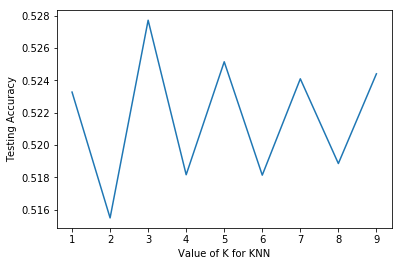

In [4]:
print(scores)

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

In [5]:
# instantiate the model with the best known parameters
knn = KNeighborsClassifier(n_neighbors=3)

# train the model with X and y (not X_train and y_train)
knn.fit(X, y)

# make a prediction for an out-of-sample observation
knn.predict(X)


print(metrics.classification_report(y_test, y_pred,digits=3))
print(metrics.recall_score(y_test,y_pred))

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


              precision    recall  f1-score   support

       False      0.446     0.681     0.539     15899
        True      0.654     0.416     0.509     23046

   micro avg      0.524     0.524     0.524     38945
   macro avg      0.550     0.549     0.524     38945
weighted avg      0.569     0.524     0.521     38945

0.41625444762648617


In [6]:
TP = 0
for i in range(x.shape[0]):
    if x[i] == y[i] == True:
        TP = TP+1

TN = 0
for i in range(x.shape[0]):
    if x[i] == y[i] == False:
        TN = TN+1

FP = 0
for i in range(x.shape[0]):
    if (x[i] == True) and (y[i] == False):
        FP = FP+1

FN = 0
for i in range(x.shape[0]):
    if (x[i] == False) and (y[i] == True):
        FN = FN+1

tab = [["pred pos", TP, FP], ["pred neg", FN, TN]]
print(pd.DataFrame(tab, columns=["", "pos", "neg"]))
print()
print("recall", TP/(TP+FN))
print("precision", TP/(TP+FP))
print("accuracy", (TP+TN)/(TP+TN+FP+FN))


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


             pos  neg
0  pred pos    0    0
1  pred neg    0    0



ZeroDivisionError: division by zero